
<h1 style="color: #aadafa; text-align: center; font-size: 48px; margin-bottom: 0.2em;">
Exemplar-Based Image Inpainting
<h1>
<h3 style="text-align: center; color: #aadafa; font-weight: normal; margin-top: 0;">
Python Implementation of Criminisi et al. (2004)
</h3>
<p style="text-align: center; font-size: 18px; margin-top: 0.5em;">
Group project by <strong>Chloe Court & Marie Pizzini</strong> 
</p>
<p style="text-align: center; font-size: 18px; margin-top: 0.5em;">
Telecom Paris - October 2023
</p>

<h2 style="color: #71c6b1; font-size: 32px">
Paper Abstract
</h2>

**Goal of the Paper**

The paper proposes an algorithm for removing large objects from digital images by filling the missing region (the “hole”) with visually plausible background content.  
Unlike previous approaches:  
- Texture synthesis methods could extend repetitive textures but failed to respect image structures (like edges, lines).  
- Inpainting (diffusion-based) methods could propagate linear structures but introduced blur and failed on large missing areas.  
Criminisi’s method combines both approaches by:  
- Using exemplar-based patch synthesis to copy real content from the known parts of the image.  
- Guiding the filling order with a priority function that balances:  
  - a confidence term (favoring patches with more reliable known pixels),  
  - and a data term (favoring continuation of strong edges into the missing region).  

This strategy allows the algorithm to simultaneously propagate texture and structure into the hole.



<h2 style="color: #71c6b1; font-size: 32px">
Implementation 
</h2>

This project focuses on implementing the previously explained method using Python with **OpenCV** and **NumPy** libraries. The pipeline can be summarized as follows:

1. **Initialization**  
   - Load the original image and its corresponding binary mask (white = missing region).
   - Build two lists:  
     - **M**: boundary pixels (frontier of the hole).  
     - **L**: interior pixels of the hole.  
   - Initialize the**confidence map, setting pixels outside the hole to 1 and inside the hole to 0.

2. **Patch Extraction**  
   - Define a patch size.
   - Extract patches centered at a given pixel, ensuring they stay inside the image bounds.

3. **Priority Computation**  
   - For each boundary pixel in **M**, compute a **priority score** = confidence term + data term.  
   - The confidence term is the average confidence over the patch.  
   - The data term is based on the image gradient, encouraging continuation of strong edges.

4. **Best Match Search**  
   - For the highest-priority boundary patch, search the image for the most similar patch (measured by the sum of squared differences of RGB values).  
   - Only patches fully outside the hole are considered as candidates.

5. **Image & Mask Update**  
   - Copy the best-matching patch content into the target patch, but only at the missing pixels.  
   - Update the mask to mark these pixels as filled.  
   - Update the confidence map accordingly.

6. **Iteration**  
   - Repeat the process: recompute boundary list **M**, priorities, best match, and updates.  
   - Stop when no boundary pixels remain (the hole is completely filled).


This step-by-step process reproduces the core idea of Criminisi’s algorithm: **fill the hole by iteratively copying the most reliable and structurally consistent patches from the known region.**



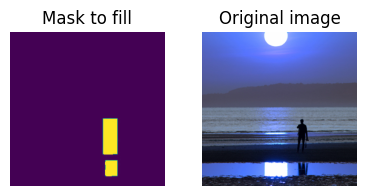

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_mask = cv2.imread('beach_256_mask.jpg', cv2.IMREAD_GRAYSCALE)
start_image = cv2.imread('beach_256.jpg', cv2.IMREAD_COLOR)
hauteur, largeur = start_image.shape[:2]
taille_patch = 13

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(image_mask)
axes[0].set_title("Mask to fill")
axes[0].axis("off")
axes[1].imshow(start_image)
axes[1].set_title("Original image")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [18]:
def update_lists(largeur, hauteur, image_mask):
    """
    Build two lists of pixels from a binary mask:
    - M: boundary pixels of the hole (frontier)
    - L: interior pixels of the hole

    A pixel belongs to the hole if its value in `image_mask` is 255.
    Among these:
    - If at least one 4-neighbor (up, down, left, right) is not 255, the pixel is added to M.
    - Otherwise, it is added to L.

    Returns
    -------
    M : list of tuple
        List of (x, y) coordinates of boundary pixels.
    L : list of tuple
        List of (x, y) coordinates of interior pixels.
"""
    L=[]
    M=[]
    for x in range(largeur):
        for y in range(hauteur):
            if np.all(image_mask[y, x] == 255):            
                if np.any(
                    [(image_mask[y - 1, x] != 255),
                    (image_mask[y + 1, x] != 255),
                    (image_mask[y, x - 1] != 255),
                    (image_mask[y, x + 1] != 255)]
                ):
                    M.append((x, y))
                else:
                    L.append((x, y))
    return M,L

In [19]:
def getCentrePatchsPleinsZone(image_mask, taille_patch):
    """
    Compute valid patch-center coordinates for exemplar sampling.

    The function builds two binary masks via morphological dilation:
    1) `sampling_zone_img`: a broad dilated region around the hole that defines where we are allowed to sample patch centers from.
    2) `invalid_patch_center_mask`: centers for which a patch of size `taille_patch` would intersect the hole (the patch would contain at least one
       masked pixel). These centers are excluded.

    Valid centers are those that lie in the sampling zone AND are not marked invalid. The function
    returns their (x, y) coordinates.

    Returns
    -------
    list[tuple[int, int]]
        List of valid center coordinates as (x, y) pairs.
    """
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (200, 200))
    sampling_zone_img = cv2.dilate(image_mask, kernel1, iterations=1)

    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (taille_patch, taille_patch))
    invalid_patch_center_mask = cv2.dilate(image_mask, kernel2, iterations=1)

    valid_centers_mask = (sampling_zone_img == 255) & (invalid_patch_center_mask == 0)
    ys, xs = np.where(valid_centers_mask)
    return list(zip(xs.tolist(), ys.tolist()))

In [20]:
def patch(height,width, image, i, j, patch_size):
    """
    Extract a square patch of size `patch_size x patch_size` centered at (i, j).
    The function returns a view into `image` when the patch fits entirely within bounds; otherwise it returns `None`.
    """
    
    r = patch_size // 2  
    y0, y1 = j - r, j - r + patch_size
    x0, x1 = i - r, i - r + patch_size

    if y0 < 0 or x0 < 0 or y1 > height or x1 > width:
        return None  
    return image[y0:y1, x0:x1]

In [21]:
def distance(hauteur, largeur, image, image_mask, centre_src, centre_tgt, patch_size):
    """
    Compute the SSD (sum of squared differences) between a source patch and a target patch,
    restricted to known (unmasked) pixels in the target patch. Returns +inf if either patch
    is out of bounds or if the source patch intersects the hole.

    The comparison is performed on RGB channels after casting to int32 to
    avoid uint8 overflow. Only pixels where `image_mask` at the target patch is != 255
    contribute to the distance. If any pixel in the source patch is masked, the source patch is rejected and +inf is returned.

    Parameters
    ----------
    centre_src : tuple[int, int]
        (x, y) center of the candidate source patch (assumed to be fully known).
    centre_tgt : tuple[int, int]
        (x, y) center of the target patch to compare against.
    patch_size : int
        Side length of the square patch (typically odd).

    Returns
    -------
    float
        SSD value over known pixels of the target patch; +inf if the source patch touches the hole
        or if either patch falls out of image bounds.
    """
    p_src = patch(hauteur, largeur, image,      centre_src[0], centre_src[1], patch_size)
    p_tgt = patch(hauteur, largeur, image,      centre_tgt[0], centre_tgt[1], patch_size)
    m_src = patch(hauteur, largeur, image_mask, centre_src[0], centre_src[1], patch_size)
    m_tgt = patch(hauteur, largeur, image_mask, centre_tgt[0], centre_tgt[1], patch_size)

    if p_src is None or p_tgt is None or m_src is None or m_tgt is None:
        return float('inf')
    
    if np.any(m_src == 255):
        return float('inf')
    known = (m_tgt != 255)
    ps = p_src.astype(np.int32)
    pt = p_tgt.astype(np.int32)
    diff = ps - pt
    

    sq = np.sum(diff**2, axis=2)
    ssd = float(np.sum(sq[known]))

    return float(ssd)

In [22]:
def getBetterPatch(hauteur, largeur, image, image_mask, taille_patch, pixelBordure):
    """
    Find the best-matching source patch for a given boundary pixel using SSD,
    among candidate centers whose patches do not intersect the hole.

    The function:
    1) Enumerates candidate centers with `getCentrePatchsPleinsZone(image_mask, taille_patch)`.
    2) For each candidate `pixel`, computes the SSD distance to the target patch centered at `pixelBordure` via `distance(...)`.
    3) Keeps the candidate with the minimal distance (early-exits if distance == 0).
    4) Returns the best source patch and its center coordinates.

    Returns
    -------
    tuple[np.ndarray | None, tuple[int, int]]
        - The best source patch as a NumPy view into `image`
          (shape (patch, patch, C) or (patch, patch)), or `None` if the patch is out of bounds.
        - The center (x, y) of that best source patch.
    """
    min_distance = float('inf')
    min_pixel=()
    for pixel in getCentrePatchsPleinsZone(image_mask, taille_patch):
        if (distance(hauteur, largeur, image, image_mask, pixel, pixelBordure, taille_patch)<min_distance):
            min_distance=distance(hauteur, largeur, image, image_mask, pixel, pixelBordure, taille_patch)
            min_pixel=pixel
            if(min_distance==0):
                break
    return (patch(hauteur, largeur, image,min_pixel[0],min_pixel[1],taille_patch), min_pixel)


In [23]:
def initialize_confiance(image_mask):
    """
    Initialize the confidence map used in Criminisi-style inpainting.

    All known pixels (mask != 255) start with confidence 1.0, and all hole
    pixels (mask == 255) start with confidence 0.0.

    Returns
    -------
    np.ndarray
        2D float32 confidence map of the same shape as `image_mask`,
        with values in {0.0, 1.0} initially.

    """
    conf = np.ones(image_mask.shape, dtype=np.float32)
    conf[image_mask == 255] = 0.0
    return conf

def update_confiance(confiance, centre_patch_à_remplir):
    """
    Update the confidence map after filling a target patch.

    Sets the confidence inside the target patch window centered at
    `centre_patch_à_remplir` to the ratio of known pixels within that window, where S counts pixels whose mask == 0.

    Parameters
    ----------
    confiance : np.ndarray
        Current 2D confidence map (float32).
    centre_patch_à_remplir : tuple[int, int]
        (x, y) center of the target patch that has just been filled.

    Returns
    -------
    np.ndarray
        Updated confidence map.
    """
    S=0
    for i in range(centre_patch_à_remplir[0]-taille_patch//2, centre_patch_à_remplir[0] + taille_patch//2 + 1):
        for j in range(centre_patch_à_remplir[1]-taille_patch//2, centre_patch_à_remplir[1] + taille_patch//2 + 1):
            if(image_mask[j,i]==0):
                S+=1
    for i in range(centre_patch_à_remplir[0]- taille_patch//2, centre_patch_à_remplir[0] + taille_patch//2 + 1):
        for j in range(centre_patch_à_remplir[1]- taille_patch//2, centre_patch_à_remplir[1] + taille_patch//2 + 1):
            confiance[i][j]=S/(taille_patch)**2
    return confiance

def getConfiancePatch(confiance, centre_patch):
    """
    Compute the (unnormalized) confidence score for a patch window.
    Sums the confidence values inside the square window of size `taille_patch` centered at `centre_patch`.

    Parameters
    ----------
    confiance : np.ndarray
        2D confidence map (float32).
    centre_patch : tuple[int, int]
        (x, y) center of the patch.

    Returns
    -------
    float
        Sum of confidence values in the patch window.
    """

    S=0
    for i in range(centre_patch[0]-taille_patch//2, centre_patch[0] + taille_patch//2 + 1):
        for j in range(centre_patch[1]-taille_patch//2, centre_patch[1] + taille_patch//2 + 1):
            S+=confiance[i][j]
    return S

def get_gradient_patch(patch_obstrue):
    """
    Estimate a data term proxy by computing the gradient magnitude over a grayscale patch.

    Converts the input color patch to grayscale via luma coefficients, inverts it
    (255 - gray), then returns the sum of absolute gradient values (Sobel-like via np.gradient).

    Parameters
    ----------
    patch_obstrue : np.ndarray
        Color patch array of shape (H, W, 3) in uint8.

    Returns
    -------
    float
        Sum of absolute gradients over the grayscale patch.
    """
    r, g, b = patch_obstrue[:, :, 0], patch_obstrue[:, :, 1], patch_obstrue[:, :, 2]
    rgb_float = 0.2989 * r + 0.5870 * g + 0.1140 * b
    #on passe l'image en grayscale
    for i in range(len(rgb_float)):
        for j in range(len(rgb_float[0])):
            rgb_float[i][j] = 255-int(rgb_float[i][j])
    return (np.sum(np.abs(np.gradient(rgb_float))))

def update_image_mask(centre_patch_à_remplir):
    """
    Update the binary mask after filling a target patch.

    For all pixels inside the patch window centered at `centre_patch_à_remplir`,
    set the mask value to 0 where it was 255 (mark as filled/known).

    Parameters
    ----------
    centre_patch_à_remplir : tuple[int, int]
        (x, y) center of the patch that was just filled.
    """
    for i in range(centre_patch_à_remplir[0]-taille_patch//2, centre_patch_à_remplir[0] + taille_patch//2 + 1):
        for j in range(centre_patch_à_remplir[1]-taille_patch//2, centre_patch_à_remplir[1] + taille_patch//2 + 1):
            if(image_mask[j,i]==255):
                image_mask[j,i]=0


def update_image(hauteur, largeur, centre_patch_à_remplir, centre_patch_plein, image):
    """
    Copy pixels from a source patch into the target patch at missing locations.

    For each (x, y) inside the target window centered at `centre_patch_à_remplir`,
    if `image_mask[y, x] == 255` (missing), write the corresponding pixel from the
    source patch centered at `centre_patch_plein` into `image`.

    Parameters
    ----------
    hauteur : int
        Image height (rows).
    largeur : int
        Image width (cols).
    centre_patch_à_remplir : tuple[int, int]
        (x, y) center of the target patch window.
    centre_patch_plein : tuple[int, int]
        (x, y) center of the chosen source patch window.
    image : np.ndarray
        Image array to update in place.
    """
    count_i=0
    for i in range(centre_patch_à_remplir[0]-taille_patch//2, centre_patch_à_remplir[0] + taille_patch//2 + 1):
        count_j=0
        for j in range(centre_patch_à_remplir[1]-taille_patch//2, centre_patch_à_remplir[1] + taille_patch//2 + 1):
            if(image_mask[j,i]==255):
                image[j,i]=patch(hauteur, largeur, image, centre_patch_plein[0], centre_patch_plein[1], taille_patch)[count_j,count_i]
            count_j+=1
        count_i+=1


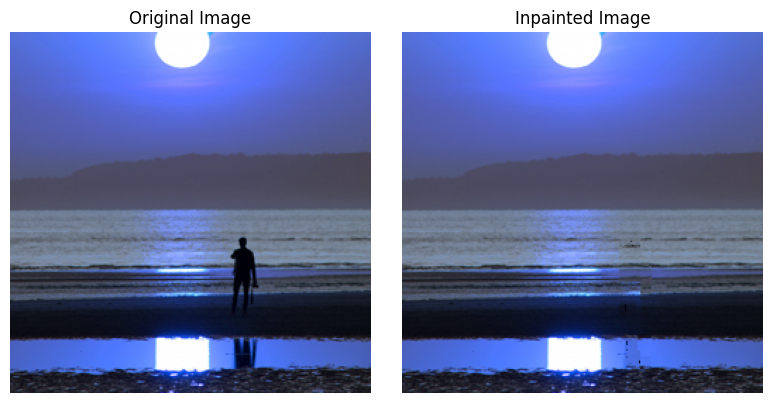

In [24]:
def main(hauteur, largeur, image, image_mask, taille_patch):
    M,L=update_lists(largeur, hauteur, image_mask)
    confiance = initialize_confiance(image_mask)
    while(len(M)!=0):
        best_pixel=(0,0)
        best_priority=0
        for pixel in M:
            confidence_patch = getConfiancePatch(confiance, pixel)
            gradient_patch = get_gradient_patch(patch(hauteur, largeur, image, pixel[0], pixel[1], taille_patch))/255
            #on divise par 255 pour normaliser
            if (confidence_patch + gradient_patch > best_priority).any():
                best_priority = confidence_patch + gradient_patch
                best_pixel = pixel

        confiance = update_confiance(confiance, best_pixel)
        update_image(hauteur, largeur, best_pixel, getBetterPatch(hauteur, largeur, image, image_mask, taille_patch, best_pixel)[1], image)
        update_image_mask(best_pixel)
        M,L=update_lists(largeur, hauteur, image_mask)
    return image



inapinted_image = main(hauteur, largeur, start_image, image_mask, taille_patch)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(cv2.imread('beach_256.jpg', cv2.IMREAD_COLOR))
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(inapinted_image)
axes[1].set_title("Inpainted Image")
axes[1].axis("off")
plt.tight_layout()
plt.show()

<h2 style="color: #71c6b1; font-size: 32px">
Results and Conclusion 
</h2>

The exemplar-based inpainting algorithm was successfully implemented in Python following the method of Criminisi et al. (2004). On test images such as the *beach* example, the algorithm was able to fill the masked region with visually coherent content, reconstructing both fine textures (sand, water) and larger structures (edges of the horizon). While small to medium holes were completed with convincing quality, larger or highly structured missing regions sometimes produced visible artifacts due to limitations in patch selection and confidence updates.  

Overall, the results confirm the strength of Criminisi’s approach: combining texture synthesis with structure propagation yields more realistic inpainting than either method alone. However, the experiments also highlight potential improvements, such as optimizing the search for source patches, refining the priority function or adopting modern deep-learning–based alternatives for more complex images.
